# History

# Purpose

# TODO

https://www.kaggle.com/sz8416/6-ways-for-feature-selection

In [63]:
import pandas as pd
import numpy as np
import gc
import warnings
warnings.filterwarnings("ignore")


In [64]:
# importing the tensorflow package
import tensorflow as tf

# Checking GPU support
print(tf.test.is_built_with_cuda())  # True
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))  # True
print(tf.config.list_physical_devices('GPU'))

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [65]:
import os
import configparser

# Load external config file
config = configparser.ConfigParser()
config.read("../resources/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "02_baseline_models" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 16


In [66]:
import urllib, requests #for Telegram notifications

def send_telegram_message(message):
    """Sending messages to Telegram bot via requests.get()."""
    
    message = f"{FILENAME_NB}:\n{message}"

    # Using "try and except" to ensure that the notebook execution will not be stopped only because of problems with the bot.
    # Example: No network connection.
    # ISSUE: Be careful, an error messages will leak your Telegram Bot Token when uploaded to GitHub.
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=%s&text=%s'%(token, chat_id, urllib.parse.quote_plus(message))
        _ = requests.get(url, timeout=10)
    
    except Exception as e:
        print('\n\nSending message to Telegram Bot was not successful.\n\n')
        print(e)
        
    return None

In [67]:
application_train = pd.read_pickle(PATH_DATA_INT + "train-opt.pkl")

In [68]:
application_train.shape

(1000000, 287)

In [69]:
# Reducing the samples and working with a fractions of it
application_sample1 = application_train.loc[application_train.target==1].sample(frac=0.2, replace=False)
print('label 1 sample size:', str(application_sample1.shape[0]))

application_sample0 = application_train.loc[application_train.target==0].sample(frac=0.2, replace=False)
print('label 0 sample size:', str(application_sample0.shape[0]))

application = pd.concat([application_sample1, application_sample0], axis=0).sort_values('id')

label 1 sample size: 100097
label 0 sample size: 99903


In [70]:
application.shape

(200000, 287)

In [71]:
X = application.drop(['id', 'target'], axis=1)
y = application.target
feature_name = X.columns.tolist()

# Feature Selection: 6 Way Approach

## 1. Pearson Correlation

In [72]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)

    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]

    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()

    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [73]:
cor_support, cor_feature = cor_selector(X, y)
print(str(len(cor_feature)), 'selected features')

100 selected features


## 2. Chi-2

In [74]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)

SelectKBest(k=100, score_func=<function chi2 at 0x000001910EC961F0>)

In [75]:
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

100 selected features


## 3. Wrapper

In [76]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=5)
rfe_selector.fit(X_norm, y)

Fitting estimator with 285 features.
Fitting estimator with 275 features.
Fitting estimator with 265 features.
Fitting estimator with 255 features.
Fitting estimator with 245 features.
Fitting estimator with 235 features.
Fitting estimator with 225 features.
Fitting estimator with 215 features.
Fitting estimator with 205 features.
Fitting estimator with 195 features.
Fitting estimator with 185 features.
Fitting estimator with 175 features.
Fitting estimator with 165 features.
Fitting estimator with 155 features.
Fitting estimator with 145 features.
Fitting estimator with 135 features.
Fitting estimator with 125 features.
Fitting estimator with 115 features.
Fitting estimator with 105 features.


RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10,
    verbose=5)

In [77]:
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

100 selected features


## 4. Embeded: Logistic Regression

In [78]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(estimator=LogisticRegression(penalty="l2"), threshold='1.25*median')
embeded_lr_selector.fit(X_norm, y)


SelectFromModel(estimator=LogisticRegression(), threshold='1.25*median')

In [79]:
embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

128 selected features


## 5. Embeded: Random Forest

In [80]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='1.25*median')
embeded_rf_selector.fit(X, y)

SelectFromModel(estimator=RandomForestClassifier(), threshold='1.25*median')

In [81]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

14 selected features


## 6. Embeded: LightGBM

In [82]:
from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, threshold='1.25*median')
embeded_lgb_selector.fit(X, y)

SelectFromModel(estimator=LGBMClassifier(colsample_bytree=0.2,
                                         learning_rate=0.05,
                                         min_child_weight=40,
                                         min_split_gain=0.01, n_estimators=500,
                                         num_leaves=32, reg_alpha=3,
                                         reg_lambda=1),
                threshold='1.25*median')

In [83]:
embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

122 selected features


## Summary: 6 Way Approach

In [84]:
pd.set_option('display.max_rows', None)
# put all selection together
feature_selection_df = pd.DataFrame({'feature':feature_name, 'pearson':cor_support, 'chi-2':chi_support, 'rfe':rfe_support, 'logistics':embeded_lr_support,
                                     'randomforest':embeded_rf_support, 'lightgbm':embeded_lgb_support})
# count the selected times for each feature
feature_selection_df['total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['total','feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(100)

,feature,pearson,chi-2,rfe,logistics,randomforest,lightgbm,total
1,f92,True,True,True,True,True,True,6
2,f8,True,True,True,True,True,True,6
3,f78,True,True,True,True,True,True,6
4,f77,True,True,True,True,True,True,6
5,f69,True,True,True,True,True,True,6
6,f58,True,True,True,True,True,True,6
7,f3,True,True,True,True,True,True,6
8,f22,True,True,True,True,True,True,6
9,f214,True,True,True,True,True,True,6
10,f200,True,True,True,True,True,True,6


In [85]:
feature_selection_df['feature'].to_csv('features_selected_6way_all.csv', index=False)

In [86]:
#feature_selection_df['feature'].head(47).to_csv('features_selected_6way_47.csv', index=False)
#feature_selection_df['Feature'].head(47).tolist()

# Feature Selection: SHAP

- https://mljar.com/blog/feature-importance-xgboost
- https://github.com/slundberg/shap

In [87]:
# Clear memory
import gc
gc.collect()

34205

In [88]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap


In [89]:
#application_train = pd.read_pickle(PATH_DATA_INT + "train-opt.pkl")

X = application_train.drop(['id','target'], axis=1).copy()
y = application_train ['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd_state) # for shap.summary_plot

In [90]:
# train an XGBoost model
params = {
    "eval_metric": "logloss", #auc
    "objective": "binary:logistic",
    "tree_method": "gpu_hist",
    # "tree_method": "hist",
    "n_jobs": n_cpu,
    "gpu_id": 0,
    "predictor": "gpu_predictor",
    # "n_estimators": 10000,
    # "learning_rate": 0.01063045229441343,
    # "gamma": 0.24652519525750877,
    # "max_depth": 4,
    "seed": rnd_state,
    # "min_child_weight": 366,
    # "subsample": 0.6423040816299684,
    # "colsample_bytree": 0.7751264493218339,
    # "colsample_bylevel": 0.8675692743597421,
    # "use_label_encoder": False,
    # "lambda": 0,
    # "alpha": 10,
}

# IMPORTANT: gpu_hist DOES NOT work with SHAP explainer
model = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", random_state=rnd_state, n_jobs=n_cpu).fit(X, y)
#model = xgb.XGBClassifier(**params).fit(X, y)

In [91]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)


In [92]:
feature_names = X.columns
feature_values = shap_values.values

feature_values_df = pd.DataFrame(feature_values, columns=feature_names)
feature_values_df.mean().reset_index().sort_values(0, ascending=False)
feature_list = list(feature_values_df.mean().sort_values(ascending = False).head(20).index)
feature_list


['f22',
 'f69',
 'f179',
 'f78',
 'f58',
 'f136',
 'f134',
 'f73',
 'f200',
 'f156',
 'f192',
 'f201',
 'f77',
 'f82',
 'f112',
 'f92',
 'f150',
 'f211',
 'f195',
 'f243']

In [93]:
message = 'SHAP important features finished.'
send_telegram_message(message)


## Visualize

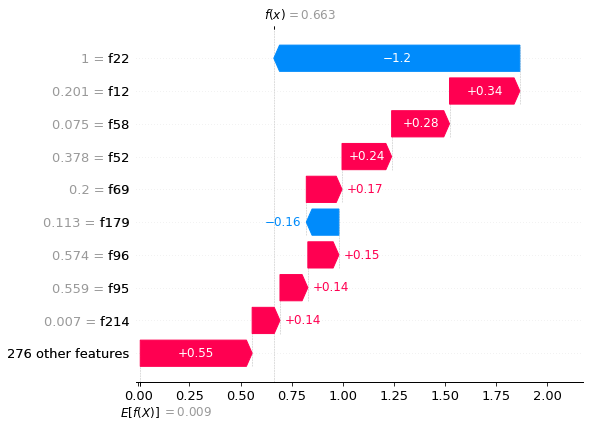

In [94]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

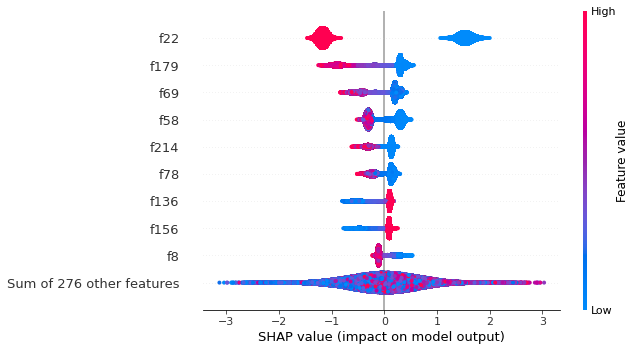

In [95]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

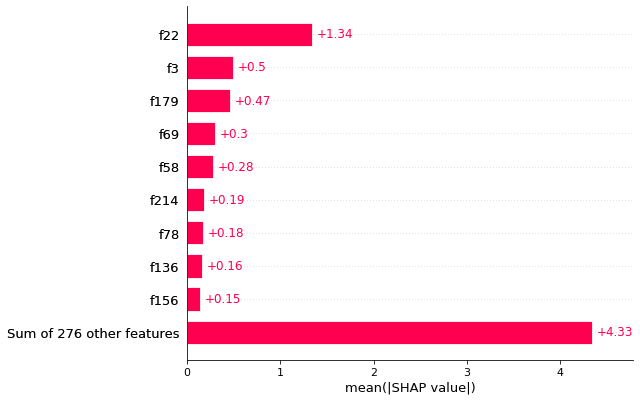

In [96]:
shap.plots.bar(shap_values)

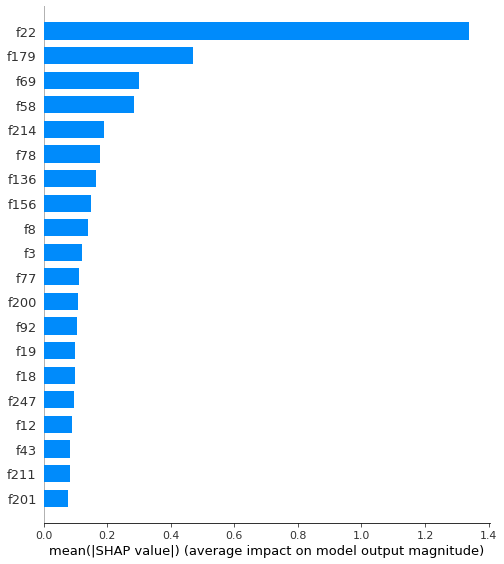

In [97]:
shap_values2 = explainer.shap_values(X_test)
shap.summary_plot(shap_values2, X_test, plot_type="bar")


In [98]:
selected_features_no = 20
#features_shap_df = feature_values_df.mean().sort_values(ascending = False).head(selected_features_no).reset_index()
features_shap_df = feature_values_df.mean().sort_values(ascending = False).reset_index()
features_shap_df.rename(columns={'index':'feature'}, inplace=True)
features_shap_df['feature']


0       f22
1       f69
2      f179
3       f78
4       f58
5      f136
6      f134
7       f73
8      f200
9      f156
10     f192
11     f201
12      f77
13      f82
14     f112
15      f92
16     f150
17     f211
18     f195
19     f243
20      f72
21     f125
22     f169
23     f130
24     f252
25     f258
26      f63
27     f231
28     f187
29     f210
30      f35
31     f265
32     f146
33      f80
34     f206
35     f154
36     f229
37      f79
38     f222
39      f27
40      f86
41     f140
42     f256
43     f233
44     f245
45      f81
46      f20
47     f101
48     f107
49     f155
50     f212
51      f70
52     f162
53     f176
54     f219
55     f110
56      f57
57     f204
58     f274
59      f36
60      f38
61     f208
62     f213
63     f239
64     f235
65     f184
66      f91
67     f230
68      f32
69      f41
70     f189
71     f260
72     f232
73     f215
74      f45
75      f24
76     f205
77     f105
78     f182
79     f135
80     f164
81     f250
82     f186
83  

In [99]:
# Save
#filename = f'features_selected_shap_{selected_features_no}.csv'
filename = f'features_selected_shap_all.csv'
features_shap_df['feature'].to_csv(filename, index=False)
